# Data collection and preprocessing

---


## Installs

In [ ]:
!pip install noisereduce

## Imports

In [ ]:
import io
import os
import glob
from pathlib import Path
import pandas as pd
import numpy as np
import noisereduce as nr
import pickle
import matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.layers as LK
import tensorflow.keras.models as MK
from keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
import gc
from sklearn import metrics
from IPython.display import Javascript, Audio
from google.colab import output
from base64 import b64decode
import warnings
from librosa.util import normalize
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Parameters

In [ ]:
fs = 44100           # Sampling rate
top_db = 20          # Silence threshold in decibels

# Mel's spectrogram parameters
n_fft_parameter = int(0.025 * fs)
hop_length_parameter = int(n_fft_parameter/2)
n_mels_parameter = 40

## Convert audios to spectrograms

In [ ]:
audioFolders = os.listdir('/content/drive/MyDrive/SEÑALES/Audios Señales')
audioFolders.sort()

for label, rawAudio in enumerate(audioFolders):
  for fileName in glob.glob(os.path.join('/content/drive/MyDrive/SEÑALES/Audios Señales', rawAudio, '*.wav')):
    try:
      signal, sr = librosa.load(fileName, mono=True, sr=fs)
      trimmed_signal = librosa.effects.trim(signal, top_db= 20)
      reduced_noise_signal = nr.reduce_noise(trimmed_signal[0], fs)
      normalized_signal = librosa.util.normalize(reduced_noise_signal)

      plt.specgram(x=normalized_signal, Fs=fs, Fc=0, NFFT=n_fft_parameter, cmap=plt.cm.jet, scale='dB')
      plt.axis('off')
      plt.savefig(f'{fileName[:-3].replace(".","")}.jpg')
      plt.clf
      plt.cla()
      plt.close()

    except Exception as e:
      print(f'Error: {e}')
      continue

print('Images saved correctly')

Images saved correctly


## Spectogram reading

In [ ]:
spectogramFolders = os.listdir('/content/drive/MyDrive/SEÑALES/Espectogramas Señales')
spectogramFolders.sort()

dataset = []

for label_spectogram, rawSpectrogram in enumerate(spectogramFolders):
  for fileNameSpecgram in glob.glob(os.path.join('/content/drive/MyDrive/SEÑALES/Espectogramas Señales', rawSpectrogram, '*.jpg')):
    try:

      img = Image.open(fileNameSpecgram)
      box = (80, 58, 576, 427)
      img_crop = img.crop(box)
      img_array = np.asarray(img_crop)
      dataset.append([img_array, label_spectogram])

    except Exception as e:
      print(f'Error: {e}')
      continue

print('Spectogram reading completed')

spectogram= pd.DataFrame(dataset, columns=['SPECTOGRAMS', 'LABEL'])

Spectogram reading completed


# Dataset

---



In [ ]:
spectogram.head()

,SPECTOGRAMS,LABEL
0,"[[[62, 231, 228], [62, 231, 228], [62, 231, 22...",0
1,"[[[8, 92, 208], [8, 92, 208], [8, 92, 208], [8...",0
2,"[[[33, 134, 216], [33, 134, 216], [33, 134, 21...",0
3,"[[[118, 238, 164], [118, 238, 164], [118, 238,...",0
4,"[[[39, 223, 233], [39, 223, 233], [40, 222, 23...",0


## Spectograms visualization

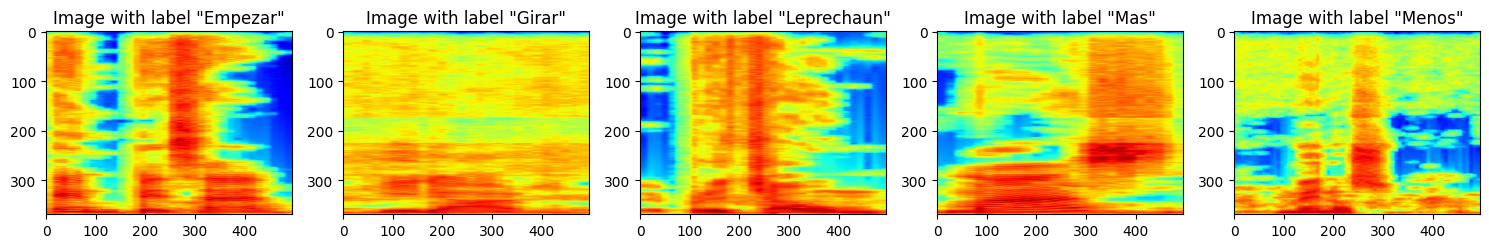

In [ ]:
indexes = [5, 145, 270, 410, 545]
labels = ['Empezar', 'Girar', 'Leprechaun', 'Mas', 'Menos']

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i, index in enumerate(indexes):
    imageSpectogram = spectogram.loc[index, 'SPECTOGRAMS']
    axs[i].imshow(imageSpectogram)
    axs[i].set_title('Image with label "{}"'.format(labels[i]))

plt.tight_layout()
plt.show()

## Partitioning

In [ ]:
x = np.array(spectogram.SPECTOGRAMS.tolist())
y = np.array(spectogram.LABEL.tolist())
y = y.reshape((y.shape[0],-1))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10, stratify=y)

print(x.shape)
print(y.shape)
print(x_train.shape, y_train.shape, y_test.shape )

(665, 369, 496, 3)
(665, 1)
(532, 369, 496, 3) (532, 1) (133, 1)


## Ensuring that they become tensors

In [ ]:
x_train = x_train.reshape((x_train.shape[0], 369, 496, 3))
x_test = x_test.reshape((x_test.shape[0], 369, 496, 3))
print("Training images Size: %s, Label size %s" %(x_train.shape, y_train.shape))
print("Test images size: {0}, Label size: {1}".format(x_test.shape, y_test.shape))

Training images Size: (532, 369, 496, 3), Label size (532, 1)
Test images size: (133, 369, 496, 3), Label size: (133, 1)


# CONVOLUTIONAL NEURAL NETWORK BASED ON VGG-19

---



In [ ]:
#CONVOLUTION

entrada = LK.Input(shape=(369, 496, 3))
conv1 = LK.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(entrada)
conv2 = LK.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(conv1)
pool1 = LK.MaxPool2D(pool_size=(2,2), strides=(2,2))(conv2)

conv3 = LK.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(pool1)
conv4 = LK.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(conv3)
pool2 = LK.MaxPool2D(pool_size=(2,2), strides=(2,2))(conv4)

conv5 = LK.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(pool2)
conv6 = LK.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(conv5)
pool3 = LK.MaxPool2D(pool_size=(2,2), strides=(2,2))(conv6)

conv7 = LK.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(pool3)
conv8 = LK.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(conv7)
pool4 = LK.MaxPool2D(pool_size=(2,2), strides=(2,2))(conv8)

conv8 = LK.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(pool4)
conv9 = LK.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(conv8)
pool5 = LK.MaxPool2D(pool_size=(2,2), strides=(2,2))(conv9)

#FLATTEN

flat = LK.Flatten()(pool5)

# NEURONAL NETWORK

fc1 = LK.Dense(units=512, activation='relu', kernel_regularizer= tf.keras.regularizers.L2(0.01))(flat)
drop = LK.Dropout(0.35)(fc1)
fc2 = LK.Dense(units=512, activation='relu', kernel_regularizer= tf.keras.regularizers.L2(0.01))(drop)
drop1 = LK.Dropout(0.4)(fc2)
fc3 = LK.Dense(units=512, activation='relu', kernel_regularizer= tf.keras.regularizers.L2(0.01))(drop1)
drop2 = LK.Dropout(0.35)(fc3)
salida = LK.Dense(units=5, activation='softmax')(drop2)

In [ ]:
#SUMMARY
gonodactylus_simithii = MK.Model(entrada, salida)
gonodactylus_simithii.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 369, 496, 3)]     0         
                                                                 
 conv2d_120 (Conv2D)         (None, 369, 496, 8)       224       
                                                                 
 conv2d_121 (Conv2D)         (None, 369, 496, 8)       584       
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 184, 248, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_122 (Conv2D)         (None, 184, 248, 16)      1168      
                                                                 
 conv2d_123 (Conv2D)         (None, 184, 248, 16)      2320      
                                                          

## Clear computer data

In [ ]:
tf.keras.backend.clear_session
gc.collect()

16046

## Training

In [ ]:
#COMPILE MODEL
gonodactylus_simithii.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
filepath = "best_trained_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max', period=2)

firstTraining = gonodactylus_simithii.fit(x_train, y_train, epochs=150, batch_size=128, validation_data=(x_test, y_test), verbose=1, callbacks=[checkpoint])

gonodactylus_simithii.load_weights(filepath)

loss, acc = gonodactylus_simithii.evaluate(x_test, y_test, verbose=1)
print("The loss is: {0}, and the accuracy is: {1}".format(loss, acc))

Epoch 1/150
5/5 [==============================] - 9s 565ms/step - loss: 20.3381 - accuracy: 0.1598 - val_loss: 16.5208 - val_accuracy: 0.2030
Epoch 2/150
5/5 [==============================] - ETA: 0s - loss: 15.1970 - accuracy: 0.1955
Epoch 2: val_accuracy improved from -inf to 0.20301, saving model to best_trained_model.h5
5/5 [==============================] - 3s 544ms/step - loss: 15.1970 - accuracy: 0.1955 - val_loss: 12.7644 - val_accuracy: 0.2030
Epoch 3/150
5/5 [==============================] - 3s 517ms/step - loss: 11.9114 - accuracy: 0.1974 - val_loss: 10.3630 - val_accuracy: 0.1955
Epoch 4/150
5/5 [==============================] - ETA: 0s - loss: 9.8071 - accuracy: 0.2105
Epoch 4: val_accuracy improved from 0.20301 to 0.21805, saving model to best_trained_model.h5
5/5 [==============================] - 3s 560ms/step - loss: 9.8071 - accuracy: 0.2105 - val_loss: 8.7493 - val_accuracy: 0.2180
Epoch 5/150
5/5 [==============================] - 3s 497ms/step - loss: 8.3231 - 

# Performance measurement

---



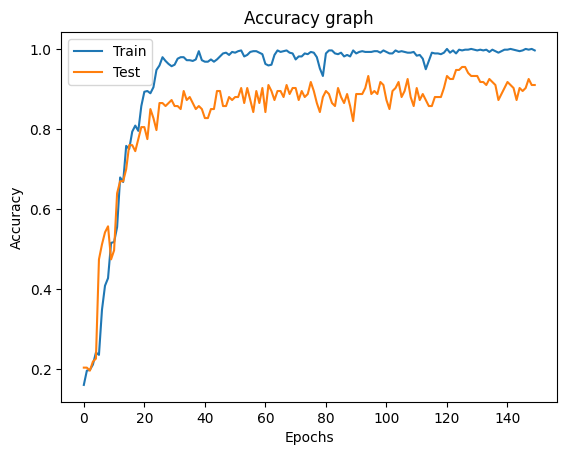

In [ ]:
plt.plot(firstTraining.history['accuracy'])
plt.plot(firstTraining.history['val_accuracy'])
plt.title("Accuracy graph")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

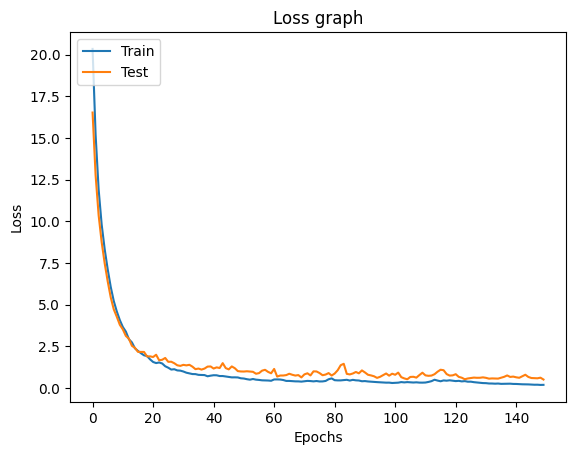

In [ ]:
plt.plot(firstTraining.history['loss'])
plt.plot(firstTraining.history['val_loss'])
plt.title("Loss graph")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

5/5 [==============================] - 0s 48ms/step


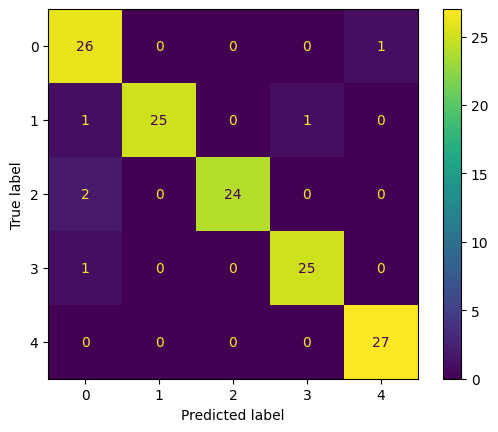

In [ ]:
y_pred = gonodactylus_simithii.predict(x_test)
result = confusion_matrix(y_test, y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(result)
disp.plot()
plt.show()

In [ ]:
resultCR = metrics.classification_report(y_test.ravel(), y_pred.argmax(axis=1))
print("Classification Report:",)
print (resultCR)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91        27
           1       1.00      0.93      0.96        27
           2       1.00      0.92      0.96        26
           3       0.96      0.96      0.96        26
           4       0.96      1.00      0.98        27

    accuracy                           0.95       133
   macro avg       0.96      0.95      0.96       133
weighted avg       0.96      0.95      0.96       133



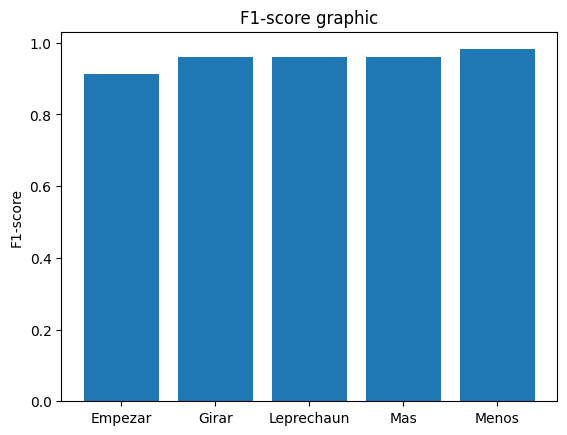

In [ ]:
report = metrics.classification_report(y_test.ravel(), y_pred.argmax(axis=1), output_dict=True)

f1_score = [report[str(i)]['f1-score'] for i in range(5)]

fig, ax = plt.subplots()
ax.bar(range(5), f1_score)
ax.set_xticks(range(5))
ax.set_xticklabels(['Empezar', 'Girar', 'Leprechaun', 'Mas', 'Menos'])
ax.set_ylabel('F1-score')
ax.set_title('F1-score graphic')
plt.show()

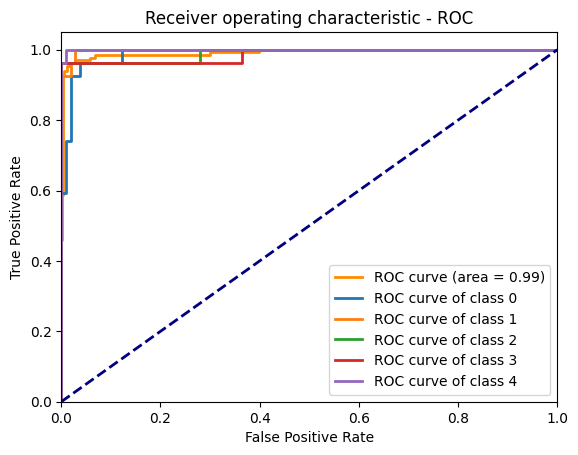

In [ ]:
y_test_binario = to_categorical(y_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test_binario[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binario.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
for i in range(5):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label="ROC curve of class {}".format(i))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - ROC')
plt.legend(loc="lower right")
plt.show()

### Save model

In [ ]:
tf.keras.saving.save_model(
    gonodactylus_simithii, 'Nika.h5', overwrite=True, save_format='h5')

In [ ]:
new_Model = MK.load_model('Nika.h5')
new_Model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 369, 496, 3)]     0         
                                                                 
 conv2d_120 (Conv2D)         (None, 369, 496, 8)       224       
                                                                 
 conv2d_121 (Conv2D)         (None, 369, 496, 8)       584       
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 184, 248, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_122 (Conv2D)         (None, 184, 248, 16)      1168      
                                                                 
 conv2d_123 (Conv2D)         (None, 184, 248, 16)      2320      
                                                          

# Testing the model

---



## Loading a test audio and processing it

In [ ]:
def testAudio(signal):

    trimmed_signal = librosa.effects.trim(signal, top_db= 20)
    reduced_noise_signal = nr.reduce_noise(trimmed_signal[0], fs)
    normalized_signal = librosa.util.normalize(reduced_noise_signal)

    fig, ax = plt.subplots()
    spectrum, frequs, t, im = ax.specgram(x=normalized_signal, Fs=fs, Fc=0, NFFT=n_fft_parameter, cmap=plt.cm.jet, scale='dB')
    ax.axis('off')
    buf = io.BytesIO()
    fig.savefig(buf, format='jpg', bbox_inches='tight', pad_inches=0, transparent=True)
    buf.seek(0)
    img = Image.open(buf)
    plt.close()

    box = (80, 58, 576, 427)
    img_crop = img.crop(box)
    img_array = np.asarray(img)

    plt.imshow(img_array, cmap='gray')
    plt.axis('off')
    plt.show()
    return img_array

## Testing the model with new audios

In [ ]:
# ["Empezar" == 0, "Girar" == 1, "Leprechaun" == 2, "Mas" == 3, "Menos" == 4]
RECORD = """
const sleep = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: {sampleSize: 16, channelCount: 1, sampleRate: 16000  }})
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec, filename='audio.wav'):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec * 1000))
  b = b64decode(s.split(',')[1])
  with open(filename, 'wb+') as f:
    f.write(b)

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

print(f"Hable máximo 2 segundos  //  Speak for a maximum of 2 seconds")
record(2,'audio.wav')

Hable máximo 2 segundos  //  Speak for a maximum of 2 seconds


<IPython.core.display.Javascript object>

In [ ]:
# Read the audio file
audio_file = 'audio.wav'
audio_data = open(audio_file, 'rb').read()

# Play the audio
Audio(audio_data)

### Predict the new audio

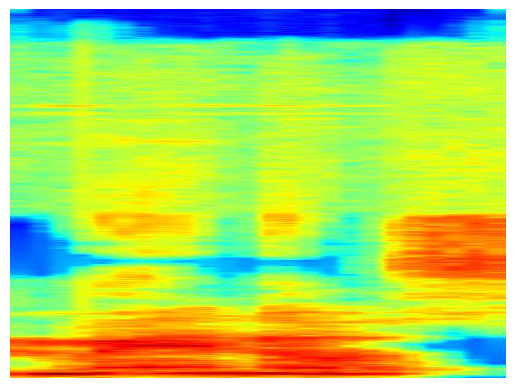

1/1 [==============================] - 0s 23ms/step
[4]
1/1 [==============================] - 0s 22ms/step
[[3.0004441e-05 7.5974542e-04 1.9550692e-04 1.0721911e-03 9.9794251e-01]]


In [ ]:
# ["Empezar" == 0, "Girar" == 1, "Leprechaun" == 2, "Mas" == 3, "Menos" == 4]
rawAudioNew, s = librosa.load(path='audio.wav', sr=fs, mono=True)
test_signals_new = testAudio(rawAudioNew)
test_signals_new = np.reshape(test_signals_new,(1, 369, 496, 3))
prediction_new = new_Model.predict(test_signals_new).argmax(axis=1)
print(prediction_new)
predictionValueNew = new_Model.predict(test_signals_new)
print(predictionValueNew)